In [16]:
from dataclasses import dataclass
from datetime import datetime

import sklearn.metrics as metrics
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np 
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from tqdm.auto import tqdm
from torchfuzzy import FuzzyLayer, DefuzzyLinearLayer, FuzzyBellLayer
import os

os.environ['CUDA_LAUNCH_BLOCKING']="1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"

In [17]:
batch_size = 256

nz = 100 
ngf = 16 
ndf = 32

niter = 50

prefix = f"fuzzy_gan_anomaly_detection"
writer = SummaryWriter(f'runs/mnist/{prefix}_{datetime.now().strftime("%Y%m%d-%H%M%S")}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Load MNIST

In [18]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x.view(-1, 28, 28) - 0.5),
])

In [19]:
# загружаем обучающую выборку

def get_target_and_mask(target_label):
    t = torch.zeros(10)
    t[target_label] = 1.0
    return t.to(device) 

train_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=True, 
    transform = transform,
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x))
)
len(train_data)

60000

In [20]:
# загружаем тестовую выборку
test_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=False, 
    transform=transform, 
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x))
)
len(test_data)

10000

In [21]:
# Создаем итераторы датасетов
train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=batch_size, 
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=False,
)


### Load EMNIST

In [22]:
emnist_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x.view(-1, 28, 28) - 0.5),
])

emnist_test = pd.read_csv("./data/EMNIST/emnist-letters.zip")
emnist_y = emnist_test["label"]
emnist_x = emnist_test.drop(labels = ["label"], axis = 1) 
del emnist_test 

emnist_x = emnist_x / 255.0
emnist_x = emnist_x.values.reshape(-1, 28, 28)
emnist_x = [torch.tensor(emnist_transform(a), dtype=torch.float32, device=device) for a in emnist_x]

len(emnist_x)

emnist_mapping = pd.read_csv("./data/EMNIST/emnist-letters-mapping.txt", sep=' ', header=None)
emnist_mapping.columns=("EMNIST","UP","LO")
emnist_mapping["Letter"] = emnist_mapping.apply(lambda row: chr(row["UP"])+chr(row["LO"]), axis=1)
emnist_mapping = dict(zip(emnist_mapping["EMNIST"], emnist_mapping["Letter"]))

emnist_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(torch.stack(emnist_x), torch.Tensor(np.array(emnist_y))), 
    batch_size=batch_size, 
    shuffle=False,
)

/tmp/ipykernel_13466/58620865.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emnist_x = [torch.tensor(emnist_transform(a), dtype=torch.float32, device=device) for a in emnist_x]


## DCGAN Model

In [23]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [24]:
class Generator(nn.Module):
    def __init__(self, ngf, nz, nc=1):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(    ngf,      nc, kernel_size=1, stride=1, padding=2, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        output = self.main(input)
        return output

netG = Generator(ngf, nz).to(device)
netG.apply(weights_init)
num_params = sum(p.numel() for p in netG.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params:,}')

print(netG)

Number of parameters: 377,328
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(16, 1, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2), bias=False)

In [25]:
class Discriminator(nn.Module):
    def __init__(self, ndf):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, ndf, 4, 2, 1, bias=False),
            nn.SiLU(),
            
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.SiLU(),
            
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.SiLU(),
            
            nn.Conv2d(ndf * 4, 1, 2, 1, 1, bias=False),
            nn.Flatten(),
            nn.Linear(16, 2),
        )
        self.latent_dim = 2
        self.fuzzy_rules_real = 10
        self.fuzzy_rules_fake = 20
        
        self.real = nn.Sequential(
            FuzzyLayer.from_dimensions(self.latent_dim, self.fuzzy_rules_real),
            DefuzzyLinearLayer.from_array(np.repeat( 1.0 / self.fuzzy_rules_real, self.fuzzy_rules_real).reshape(1,-1), trainable=False, with_norm=False)
        )
        
    def forward(self, input):
        output = self.main(input)
        r = self.real(output)
        return r.squeeze()
    

netD = Discriminator(ndf).to(device)
netD.apply(weights_init)
num_params = sum(p.numel() for p in netD.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params:,}')
print(netD)

Number of parameters: 165,332
Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): SiLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): SiLU()
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): SiLU()
    (8): Conv2d(128, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), bias=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=16, out_features=2, bias=True)
  )
  (real): Sequential(
    (0): FuzzyLayer(
      (rots): ParameterList(  (0): Parameter containing: [torch.float32 of size 10x1 (cuda:0)])
    )
    (1): DefuzzyLinearLayer()
  )
)


In [26]:
inp = torch.rand(4, 1, 28, 28).to(device)
dd = Discriminator(1).to(device)
dd(inp)

tensor([0.2719, 0.2716, 0.2761, 0.2896], device='cuda:0',
       grad_fn=<SqueezeBackward0>)

## Train

In [27]:
optimizerD = torch.optim.AdamW(netD.parameters(), lr=0.001, betas=(0.5, 0.999))
optimizerG = torch.optim.AdamW(netG.parameters(), lr=0.001, betas=(0.5, 0.999))

fixed_noise_for_report = torch.randn(64, nz, 1, 1, device=device)

In [28]:
def keep_eigenvals_positive_loss(layer, eps = 1e-3):
    ev = layer.get_transformation_matrix_eigenvals().real.min()
    ev = torch.clamp(ev, max=eps)
    return -ev

In [29]:
def get_test_arate_distr(D):
    with torch.no_grad():
        firing_levels = []
        lab_true = []
        lab_pred = []

        for data, _ in tqdm(test_loader, desc='Test MNIST', disable=True):
            data = data.view((-1,1,28,28)).to(device)
            rates = D(data)
            firing_levels.append(rates.cpu().numpy())
            

        firing_levels = np.concatenate(firing_levels, axis=0)
        for p in firing_levels:
            lab_true.append(1)
            lab_pred.append(p)

        for data, _ in tqdm(emnist_loader, desc='Test EMNIST', disable=True):
            data = data.view((-1, 1, 28, 28)).to(device) 
            arate = D(data)
            
            for p in arate.cpu().numpy():
                lab_true.append(0)
                lab_pred.append(p)
                    
        fpr, tpr, threshold = metrics.roc_curve(lab_true, lab_pred)
        roc_auc = metrics.auc(fpr, tpr)

        return firing_levels, roc_auc, threshold

def draw_embeddings(netD, netG, epoch):
    with torch.no_grad():
        centroids_real = netD.real[0].get_centroids().detach().cpu().numpy()
        #centroids_fake = netD.fake[0].get_centroids().detach().cpu().numpy()
        
        embedings = []
        embedings_test = []
        labels_expected = []
        
        cnt = 3
    
        for data, target in tqdm(train_loader, desc='Encoding', disable=True):
            data = data.view((-1,1,28,28)).to(device)
            embeding = netD.main(data)
            embedings.append(embeding.cpu().numpy())
            labels_expected.append(np.argmax(target.squeeze(1).cpu().numpy(), axis=1))
            cnt -= 1
            if cnt < 0:
                break
            
        embedings = np.concatenate(embedings, axis=0)
        labels_expected = np.concatenate(labels_expected, axis=0)

        cnt = 3
        with torch.no_grad():
            for data, target in tqdm(test_loader, desc='Encoding', disable=True):
                data = data.view((-1,1,28,28)).to(device)
                embeding = netD.main(data)
                embedings_test.append(embeding.cpu().numpy())
                cnt -= 1
                if cnt < 0:
                    break
        embedings_test = np.concatenate(embedings_test, axis=0)

        embedings_fake = []

    
        batch_size = 256
        latent_size = 100
        
        fixed_noise = torch.randn(batch_size, latent_size, 1, 1)
        if torch.cuda.is_available():
            fixed_noise = fixed_noise.cuda()
        fake_images = netG(fixed_noise)
        embeding = netD.main(fake_images)
        embedings_fake.append(embeding.cpu().numpy())

        embedings_fake = np.concatenate(embedings_fake, axis=0)    

        fig, ax = plt.subplots()
        
        ax.scatter(embedings[:, 0], embedings[:, 1], cmap='tab10', c=labels_expected, s=4)
        ax.scatter(embedings_test[:, 0], embedings_test[:, 1], marker='+', c='blue', s = 1)
        ax.scatter(embedings_fake[:, 0], embedings_fake[:, 1], c='red', marker='o', s=1)
        ax.scatter(centroids_real[:, 0], centroids_real[:,1], marker='1', c='blue', s= 120)
        #ax.scatter(centroids_fake[:, 0], centroids_fake[:,1], marker='1', c='red', s= 120)
        
        ymin, ymax = ax.get_ylim()
        xmin, xmax = ax.get_xlim()
        szw = 100
        mesh = []
        for x in np.linspace(xmin, xmax, num=szw):
            for y in np.linspace(ymin, ymax, num=szw):
                mesh.append([x,y])

        x = np.array([a[0] for a in mesh]).reshape((szw,szw))
        y = np.array([a[1] for a in mesh]).reshape((szw,szw))
        inp = torch.FloatTensor(mesh).reshape((-1, 2)).to(device)
        z = netD.real(inp).squeeze().detach().cpu().numpy().reshape((szw,szw))
        
        z_min, z_max = z.min(), z.max()
        c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
        c.set_zorder(-1)
        fig.colorbar(c, ax=ax)
        plt.show()
        writer.add_figure('Embeddings', fig, epoch)

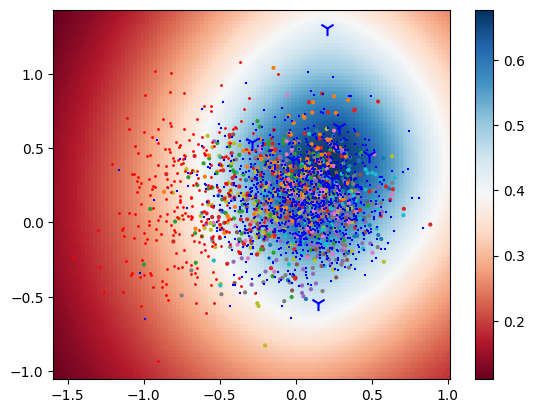

Epoch 0/50
{'G': 0.6553072622481813, 'POS': 0.5270505536109843, 'NEG': 0.2948958203830618, 'EV': 0.0, 'q20': 0.508304488658905, 'q80': 0.6411374092102051, 'auc': 0.8758509570463322}


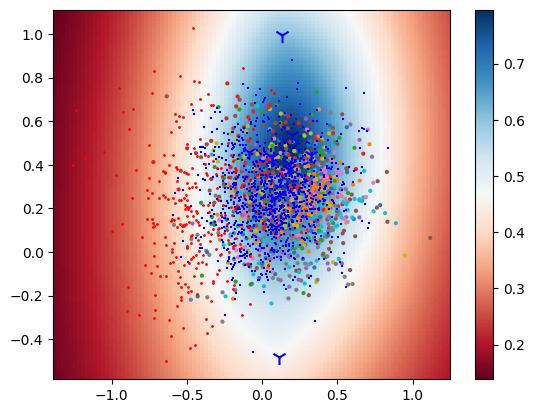

Epoch 1/50
{'G': 0.5540692711130102, 'POS': 0.5776711661764916, 'NEG': 0.34714144455625656, 'EV': 0.0, 'q20': 0.5833117485046386, 'q80': 0.7324436068534851, 'auc': 0.906398901061776}


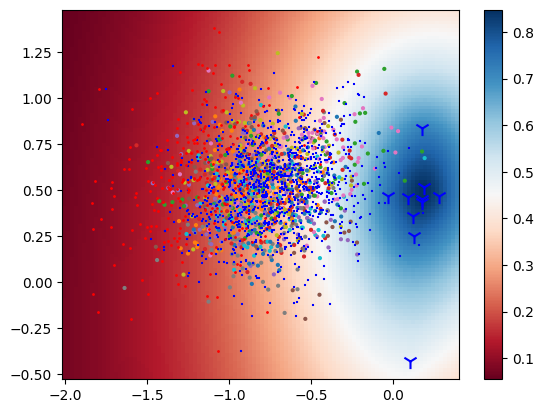

Epoch 2/50
{'G': 0.4805400145814774, 'POS': 0.5768144558084772, 'NEG': 0.40879442755212175, 'EV': 0.0, 'q20': 0.20366529524326324, 'q80': 0.374412214756012, 'auc': 0.9569916472007722}


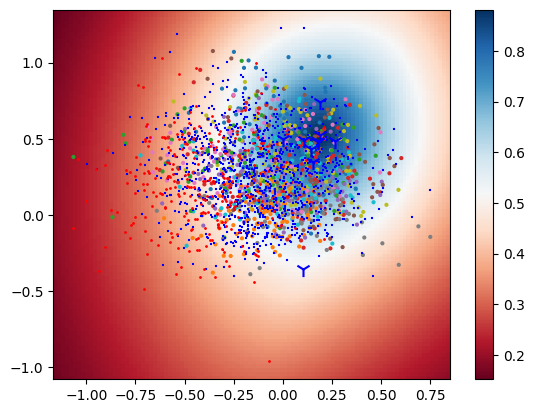

Epoch 3/50
{'G': 0.4670384770378153, 'POS': 0.5685053504527884, 'NEG': 0.40906899704578076, 'EV': 0.0, 'q20': 0.49743813276290894, 'q80': 0.7201473951339722, 'auc': 0.9860118363899614}


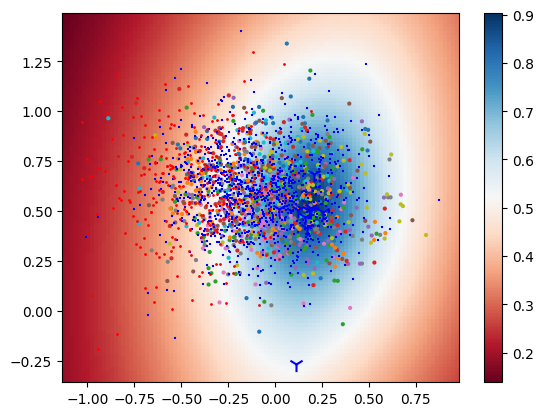

Epoch 4/50
{'G': 0.47685574128272684, 'POS': 0.5749529669893548, 'NEG': 0.4282843507350759, 'EV': 0.0, 'q20': 0.46205778717994694, 'q80': 0.767701268196106, 'auc': 0.989419500965251}


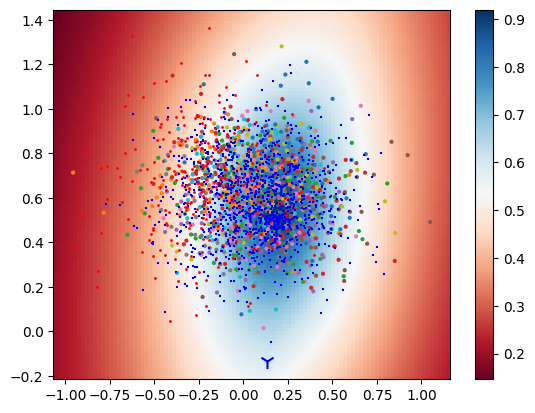

Epoch 5/50
{'G': 0.4771490546617102, 'POS': 0.5779916432309657, 'NEG': 0.42167847847684903, 'EV': 0.0, 'q20': 0.5398241877555847, 'q80': 0.810620141029358, 'auc': 0.9937257171814671}


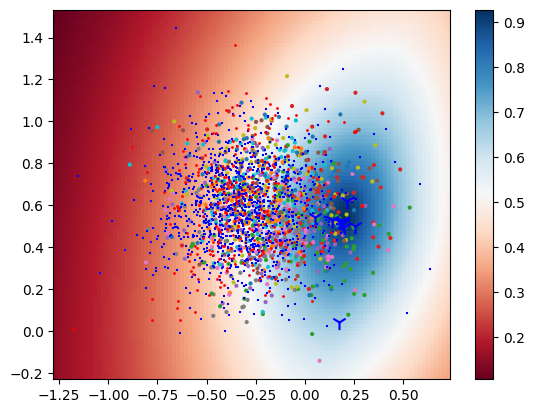

Epoch 6/50
{'G': 0.462546383954109, 'POS': 0.5765308160731133, 'NEG': 0.420733690642296, 'EV': 0.0, 'q20': 0.4140818238258362, 'q80': 0.6989509105682373, 'auc': 0.9659970651544402}


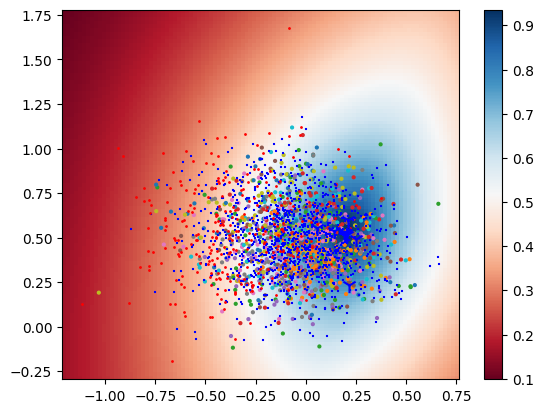

Epoch 7/50
{'G': 0.4595616991849656, 'POS': 0.5767433746698055, 'NEG': 0.4222163785645302, 'EV': 0.0, 'q20': 0.46674269437789917, 'q80': 0.7738907098770141, 'auc': 0.9929063209459459}


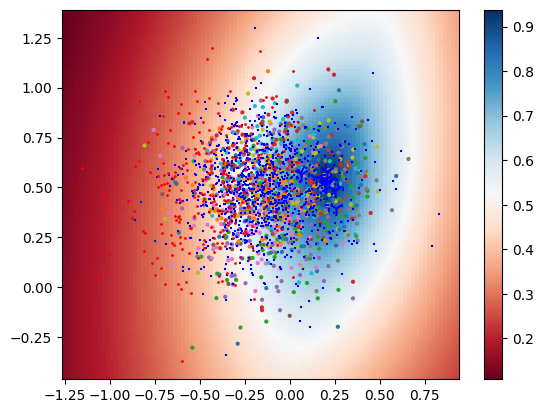

Epoch 8/50
{'G': 0.4537514379683961, 'POS': 0.5777250112371242, 'NEG': 0.42030991518751104, 'EV': 0.0, 'q20': 0.3971772611141205, 'q80': 0.7276311635971072, 'auc': 0.9913972673745174}


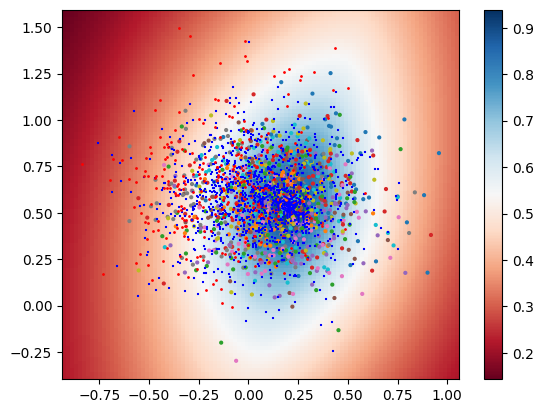

Epoch 9/50
{'G': 0.4581203743498376, 'POS': 0.5768983400248466, 'NEG': 0.42254685150816085, 'EV': 0.0, 'q20': 0.5444714546203614, 'q80': 0.8243391036987304, 'auc': 0.9906820699806952}


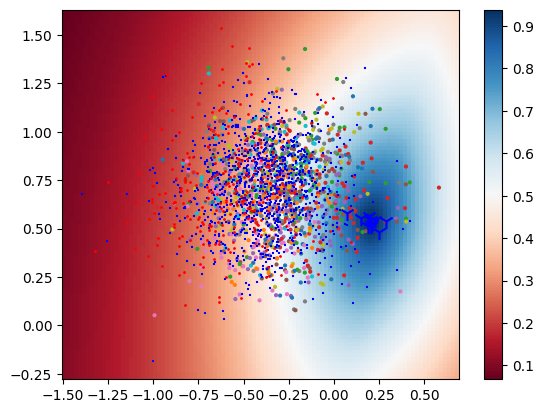

Epoch 10/50
{'G': 0.452650660276413, 'POS': 0.5808783895157753, 'NEG': 0.4201726307894321, 'EV': 0.0, 'q20': 0.274215030670166, 'q80': 0.508938479423523, 'auc': 0.9831748735521235}


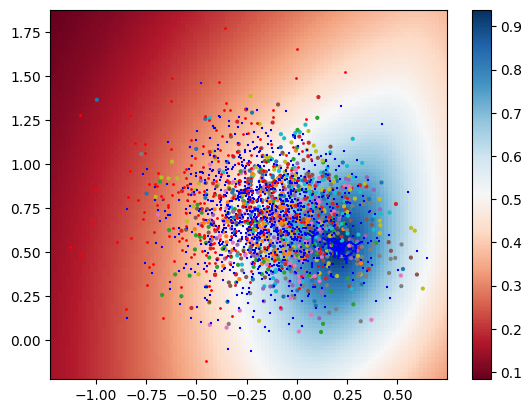

Epoch 11/50
{'G': 0.45960590845726906, 'POS': 0.5793281198816097, 'NEG': 0.41478733071621426, 'EV': 0.0, 'q20': 0.38393203616142274, 'q80': 0.7109300136566162, 'auc': 0.9904826877413129}


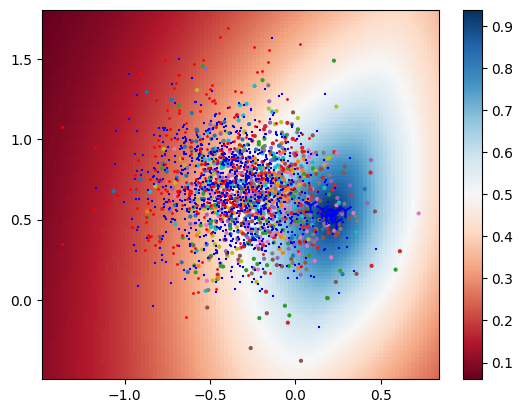

Epoch 12/50
{'G': 0.44663631548272803, 'POS': 0.5848365947287133, 'NEG': 0.41312379158557727, 'EV': 0.0, 'q20': 0.29356369376182556, 'q80': 0.5838274359703064, 'auc': 0.9885236621621621}


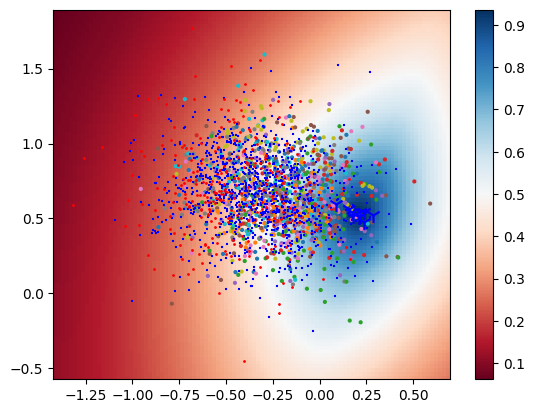

Epoch 13/50
{'G': 0.4543456420619437, 'POS': 0.5813260349821537, 'NEG': 0.41346450219763087, 'EV': 0.0, 'q20': 0.3202890813350677, 'q80': 0.6092124819755554, 'auc': 0.9774669087837837}


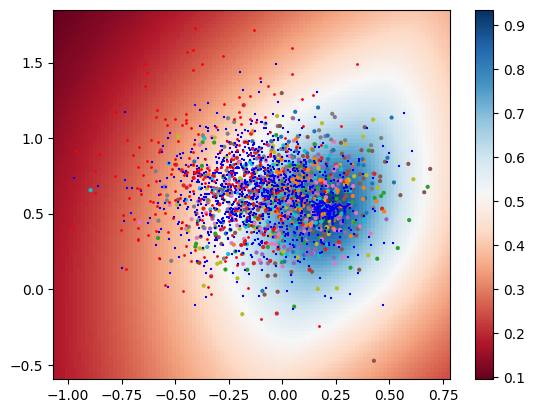

Epoch 14/50
{'G': 0.4518405689838085, 'POS': 0.5852127156359084, 'NEG': 0.4110267370305163, 'EV': 0.0, 'q20': 0.4181953430175781, 'q80': 0.733884859085083, 'auc': 0.9943069353281855}


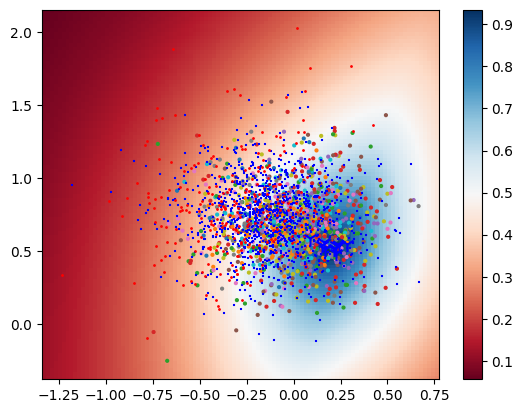

Epoch 15/50
{'G': 0.45261336704517935, 'POS': 0.5849153027889576, 'NEG': 0.40880052288796037, 'EV': 0.0, 'q20': 0.3898462176322937, 'q80': 0.7071062684059144, 'auc': 0.9930877277992277}


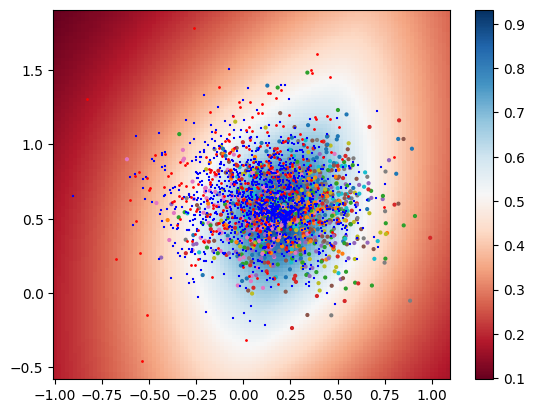

Epoch 16/50
{'G': 0.44855607329530917, 'POS': 0.5841829920068701, 'NEG': 0.40450121037503506, 'EV': 0.0, 'q20': 0.5387496709823608, 'q80': 0.817321491241455, 'auc': 0.9947327886100387}


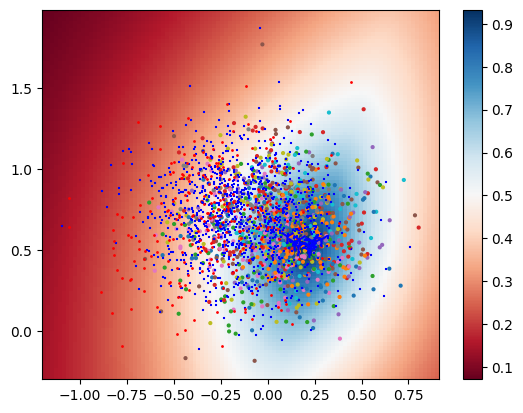

Epoch 17/50
{'G': 0.4534714625236836, 'POS': 0.5873109508702096, 'NEG': 0.40500634014606474, 'EV': 0.0, 'q20': 0.37939762473106386, 'q80': 0.7299062728881837, 'auc': 0.9831305661196912}


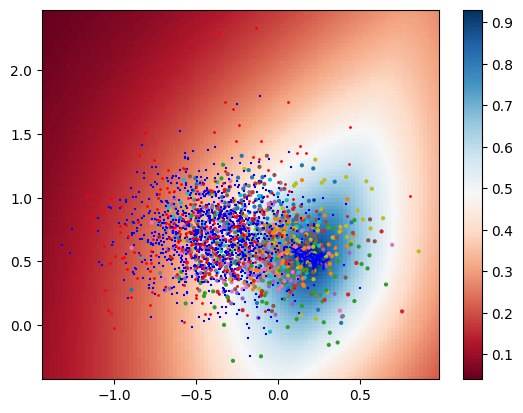

Epoch 18/50
{'G': 0.4480672911760655, 'POS': 0.5853722298398931, 'NEG': 0.4032007074102442, 'EV': 0.0, 'q20': 0.2891112446784973, 'q80': 0.5987183570861817, 'auc': 0.978548260135135}


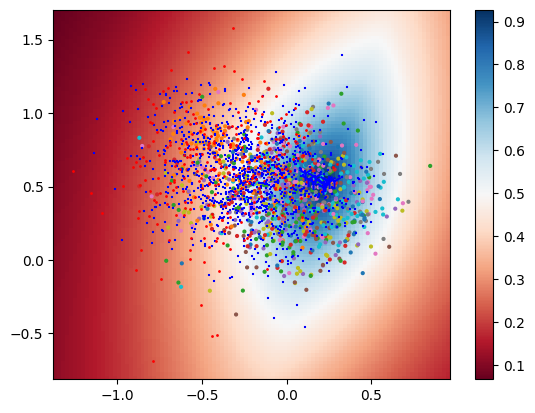

Epoch 19/50
{'G': 0.447310508629109, 'POS': 0.5884085357189178, 'NEG': 0.4027158429013922, 'EV': 0.0, 'q20': 0.3475144267082214, 'q80': 0.7139416933059692, 'auc': 0.9918511587837837}


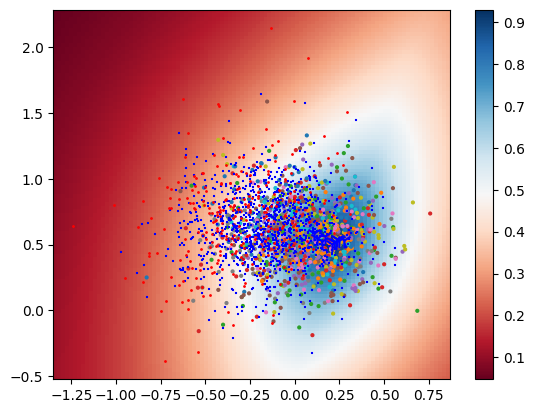

Epoch 20/50
{'G': 0.4458491202364577, 'POS': 0.590191935224736, 'NEG': 0.4021814059703908, 'EV': 0.0, 'q20': 0.37722288966178896, 'q80': 0.7103822708129884, 'auc': 0.9907780342664092}


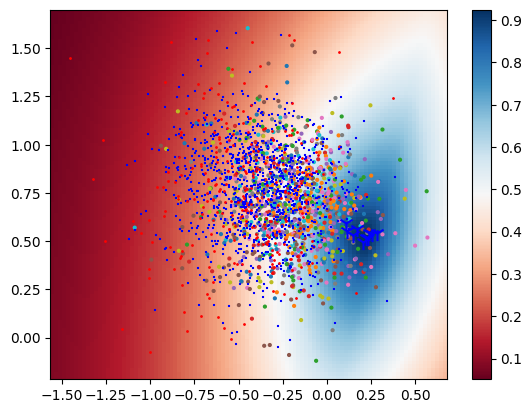

Epoch 21/50
{'G': 0.4528873264155489, 'POS': 0.5868049743327689, 'NEG': 0.39895963218617947, 'EV': 0.0, 'q20': 0.2755845248699188, 'q80': 0.5367469310760499, 'auc': 0.9815939416023167}


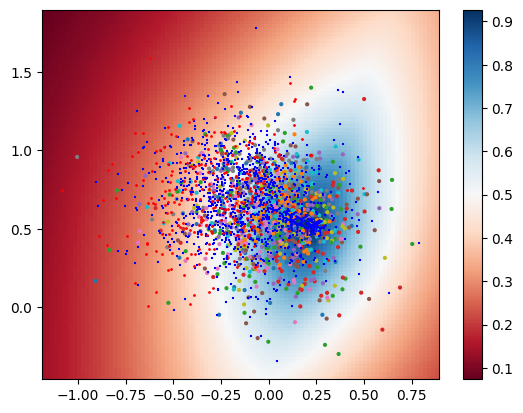

Epoch 22/50
{'G': 0.45320339152153505, 'POS': 0.5910968549708102, 'NEG': 0.39788465804242074, 'EV': 0.0, 'q20': 0.3707969069480896, 'q80': 0.7005712747573852, 'auc': 0.9889607567567568}


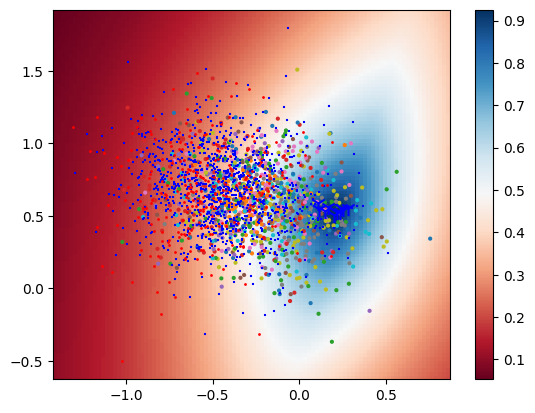

Epoch 23/50
{'G': 0.45611739799063256, 'POS': 0.5931651348763324, 'NEG': 0.39575144166642046, 'EV': 0.0, 'q20': 0.2489175021648407, 'q80': 0.5263848781585694, 'auc': 0.982844763030888}


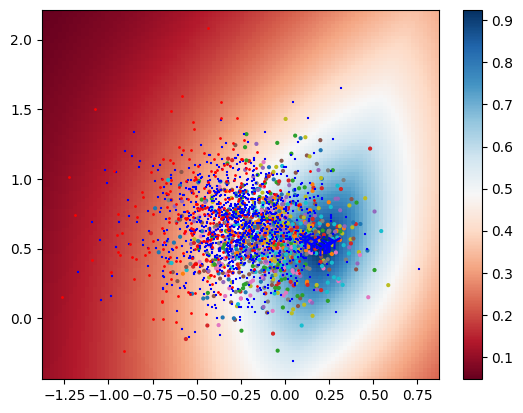

Epoch 24/50
{'G': 0.4525424588233867, 'POS': 0.5927696895092092, 'NEG': 0.3953563930506402, 'EV': 0.0, 'q20': 0.30497450232505796, 'q80': 0.5978352427482605, 'auc': 0.9892976361003861}


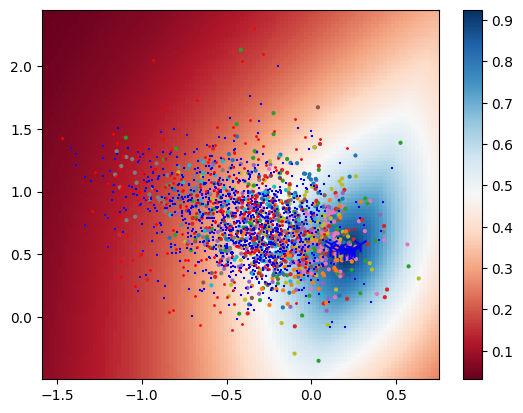

Epoch 25/50
{'G': 0.45292639117291633, 'POS': 0.5904041237019478, 'NEG': 0.3949126320316436, 'EV': 0.0, 'q20': 0.22549779415130616, 'q80': 0.5420516967773438, 'auc': 0.9710131235521235}


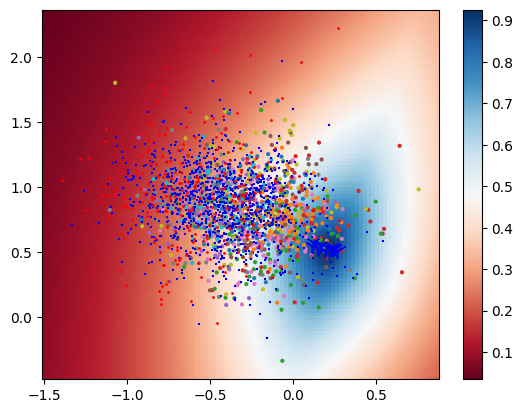

Epoch 26/50
{'G': 0.46047647988542595, 'POS': 0.596287503141038, 'NEG': 0.39344500607632577, 'EV': 0.0, 'q20': 0.20981487929821016, 'q80': 0.466946280002594, 'auc': 0.9812762953667954}


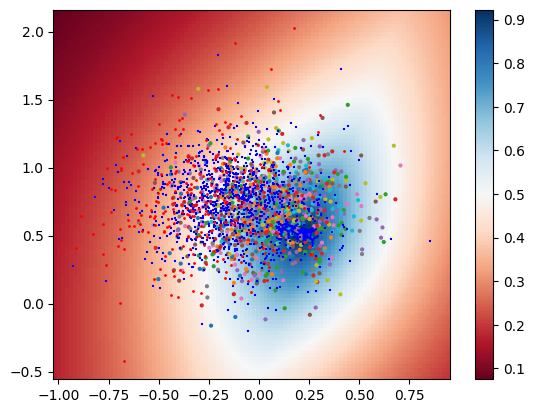

Epoch 27/50
{'G': 0.45727291132541414, 'POS': 0.5882748801657494, 'NEG': 0.38880667832303556, 'EV': 0.0, 'q20': 0.36255878806114195, 'q80': 0.6692646861076356, 'auc': 0.990771472972973}


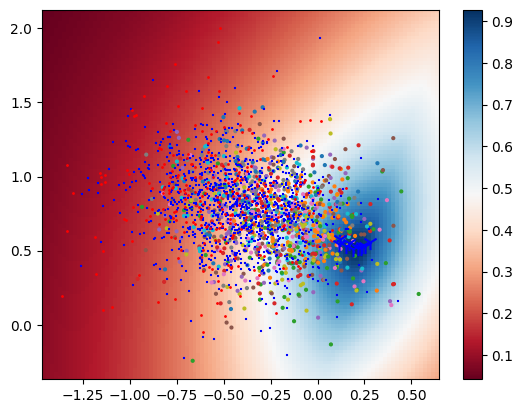

Epoch 28/50
{'G': 0.46204998011284687, 'POS': 0.6011446772737706, 'NEG': 0.38994435687014395, 'EV': 0.0, 'q20': 0.24388472735881805, 'q80': 0.5076185941696167, 'auc': 0.9723477794401545}


KeyboardInterrupt: 

In [30]:
netG.train()
netD.train()

for epoch in range(niter):
    report_aver_pos = 0
    report_aver_neg = 0
    report_loss_G = 0
    report_ev = 0
    local_count = 0
    
    for i, data in enumerate(tqdm(train_loader, desc='Training', disable=True)):
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        
        netD.zero_grad()
        
        firing = netD(real_cpu)
        
        errD_real = torch.square(1 - firing).mean()
        ev_loss = keep_eigenvals_positive_loss(netD.real[0])
        if ev_loss > 0:
            errD_real.backward(retain_graph=True)
            ev_loss.backward()
        else:
            errD_real.backward()
        report_ev = np.maximum(report_ev, ev_loss.item())
        
        nfiring = netD(fake.detach())
        errD_fake = torch.square(nfiring).mean()
        ev_loss = keep_eigenvals_positive_loss(netD.real[0])
        if ev_loss > 0:
            errD_fake.backward(retain_graph=True)
            ev_loss.backward()
        else:
            errD_fake.backward()
        report_ev = np.maximum(report_ev, ev_loss.item())
        
        optimizerD.step()
        
        netD.zero_grad()
        netG.zero_grad()
        genr = netD(fake)
        errG = torch.square(genr - 1).mean() 
        errG.backward()
        optimizerG.step()
        
        local_count += 1
        report_loss_G += errG.item()
        report_aver_pos += firing.mean().item()
        report_aver_neg += nfiring.mean().item()
        
    with torch.no_grad():
        losses = {}
        
        losses['G'] = report_loss_G / local_count
        losses['POS'] = report_aver_pos / local_count
        losses['NEG'] = report_aver_neg / local_count
        losses['EV'] = report_ev
        
        writer.add_scalars('Loss', losses, epoch)
        fake = netG(fixed_noise_for_report)
        writer.add_images('Generated images', fake.detach(), epoch)
        draw_embeddings(netD, netG, epoch)    
        
        mnist_distr, auc, _ = get_test_arate_distr(netD)
        mnist_distr_q = {}
        mnist_distr_q["q20"] = np.quantile(mnist_distr, 0.2)
        mnist_distr_q["q80"] = np.quantile(mnist_distr, 0.8)
        writer.add_scalars("MNIST test  firings", mnist_distr_q, epoch)
        writer.add_scalar("AUC", auc, epoch)
        mnist_distr_q["auc"] = auc
        
        print(f"Epoch {epoch}/{niter}")
        print({**losses, **mnist_distr_q})
    

In [31]:
torch.save(netD.state_dict(), 'weights/netD.pth')
torch.save(netG.state_dict(), 'weights/netG.pth')

## Валидация

In [32]:
D = Discriminator(ndf).to(device)
G = Generator(ngf, nz).to(device)
D.load_state_dict(torch.load('weights/netD.pth'))
G.load_state_dict(torch.load('weights/netG.pth'))
#DO NOT USE EVAL

<All keys matched successfully>

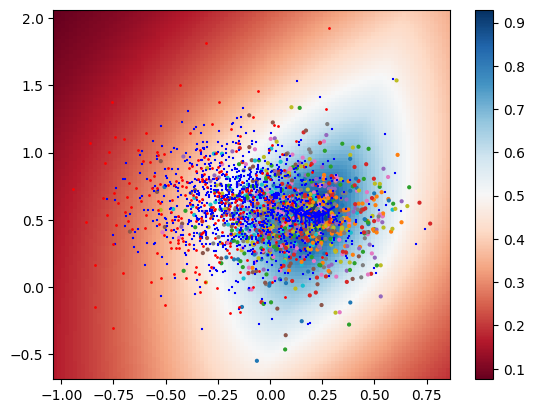

In [33]:
draw_embeddings(D, G, niter)

In [34]:
firings, auc, threshold = get_test_arate_distr(D)
print(F"Average firing {firings.mean()}")
print(F"AUC {auc} Threshold {threshold}")


Average firing 0.5755471587181091
AUC 0.9912661954633204 Threshold [          inf 9.2993689e-01 9.2555243e-01 ... 2.0128027e-02 2.0127328e-02
 6.5240223e-04]


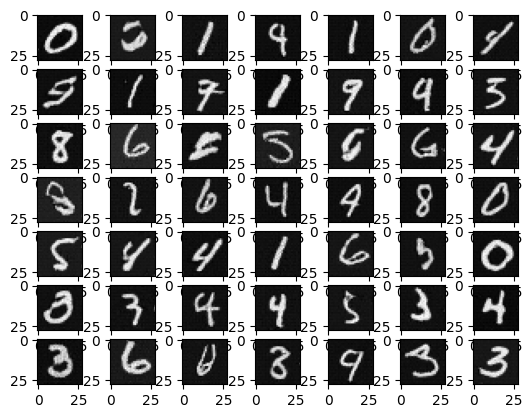

In [35]:
with torch.no_grad():
    batch_size = 49
    latent_size = 100
    
    fixed_noise = torch.randn(batch_size, latent_size, 1, 1)
    if torch.cuda.is_available():
        fixed_noise = fixed_noise.cuda()
    fake_images = G(fixed_noise)

    fake_images_np = fake_images.cpu().detach().numpy()
    fake_images_np = fake_images_np.reshape(fake_images_np.shape[0], 28, 28)
    R, C = 7, 7
    for i in range(batch_size):
        plt.subplot(R, C, i + 1)
        plt.imshow(fake_images_np[i], cmap='gray')
    plt.show()

In [36]:
def get_arate(inp):
    return D(inp)

inp = torch.rand((2,1,28,28))
get_arate(inp.to(device))

tensor([0.2940, 0.1074], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [37]:
centroids_r = D.real[0].get_centroids().detach().cpu().numpy()
centroids_r

array([[0.12321657, 0.57431597],
       [0.27692577, 0.5697489 ],
       [0.15070516, 0.53543043],
       [0.23719993, 0.53882134],
       [0.24966995, 0.53753096],
       [0.22827017, 0.5261037 ],
       [0.21658383, 0.524609  ],
       [0.16739254, 0.5556659 ],
       [0.11865224, 0.54784095],
       [0.18738164, 0.5150614 ]], dtype=float32)

Encoding:   0%|          | 0/40 [00:00<?, ?it/s]

Encoding:   0%|          | 0/405 [00:00<?, ?it/s]

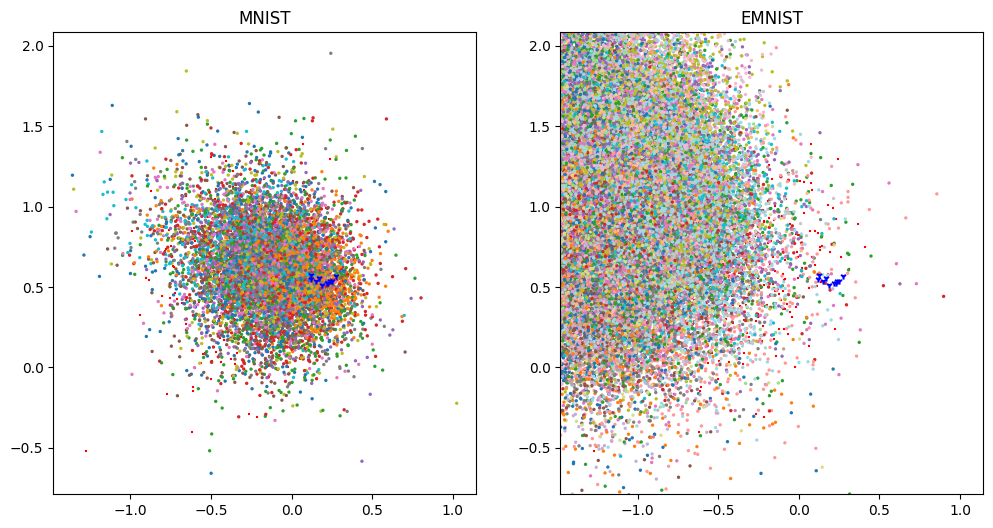

In [38]:
embedings_fake = []

with torch.no_grad():
    batch_size = 256
    latent_size = 100
    
    fixed_noise = torch.randn(batch_size, latent_size, 1, 1)
    if torch.cuda.is_available():
        fixed_noise = fixed_noise.cuda()
    fake_images = G(fixed_noise)
    embeding = D.main(fake_images)
    embedings_fake.append(embeding.cpu().numpy())

embedings_fake = np.concatenate(embedings_fake, axis=0)    

embedings = []
labels_expected = []
with torch.no_grad():
    for data, target in tqdm(test_loader, desc='Encoding'):
        data = data.view((-1,1,28,28)).to(device)
        embeding = D.main(data)
        embedings.append(embeding.cpu().numpy())
        labels_expected.append(np.argmax(target.squeeze(1).cpu().numpy(), axis=1))
embedings = np.concatenate(embedings, axis=0)
labels_expected = np.concatenate(labels_expected, axis=0)

emnist_embedings = []
emnist_labels_expected = []
with torch.no_grad():
    for data, target in tqdm(emnist_loader, desc='Encoding'):
        data = data.view((-1,1,28,28)).to(device)
        embeding = D.main(data)
        emnist_embedings.append(embeding.cpu().numpy())
        emnist_labels_expected.append(target.cpu().numpy())
emnist_embedings = np.concatenate(emnist_embedings, axis=0)
emnist_labels_expected = np.concatenate(emnist_labels_expected, axis=0)
plt.figure(figsize=(12, 6))

R, C = 1, 2

plt.subplot(R, C, 1)
plt.title("MNIST")
plt.scatter(embedings_fake[:, 0], embedings_fake[:, 1], c='red', marker='+', s=4)
plt.scatter(embedings[:, 0],      embedings[:,  1], c=labels_expected, cmap='tab10', s=2)
plt.scatter(centroids_r[:, 0],    centroids_r[:,1], marker='1', c='blue', s= 20)
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
plt.subplot(R, C, 2)
plt.title("EMNIST")
plt.scatter(embedings_fake[:, 0], embedings_fake[:, 1], c='red', marker='+', s=4)
plt.scatter(emnist_embedings[:, 0], emnist_embedings[:, 1], c=emnist_labels_expected, cmap='tab20', s=2)
plt.scatter(centroids_r[:, 0], centroids_r[:, 1], marker='1', c='blue', s= 20)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.show()

MNIST HIST:   0%|          | 0/40 [00:00<?, ?it/s]

EMNIST HIST:   0%|          | 0/405 [00:00<?, ?it/s]

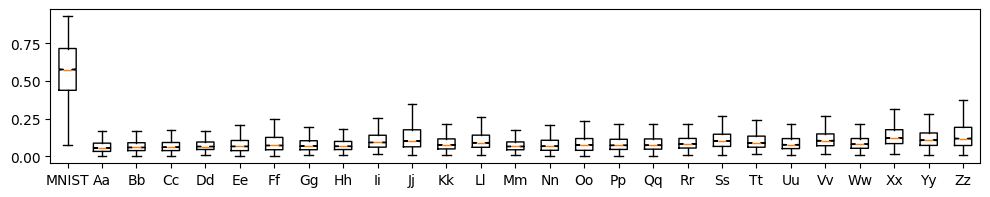

In [39]:
firing_levels = []
with torch.no_grad():
    for data, target in tqdm(test_loader, desc='MNIST HIST'):
        data = data.view((-1,1,28,28)).to(device)
        rates = get_arate(data)
        firing_levels.append(rates.cpu().numpy())
        
firing_levels = np.concatenate(firing_levels, axis=0)

firings_emnist = {}
for m in emnist_mapping:
    firings_emnist[emnist_mapping[m]] = []

with torch.no_grad():
    for data, labels in tqdm(emnist_loader, desc='EMNIST HIST'):
        data = data.view((-1, 1, 28, 28)).to(device) 
        arate = get_arate(data)
        for label, flabel in zip(labels, arate.cpu().numpy()):
            firings_emnist[emnist_mapping[label.item()]].append(flabel)

firings_mnist = {}
firings_mnist['MNIST'] = firing_levels
firings = {**firings_mnist, **firings_emnist} 
labels, data = firings.keys(), firings.values()

fig = plt.figure(figsize =(12, 2))
plt.boxplot(data, notch=True, showfliers=False)
plt.xticks(range(1, len(labels) + 1), labels)
plt.show()

writer.add_figure('Anomaly Detection', fig)

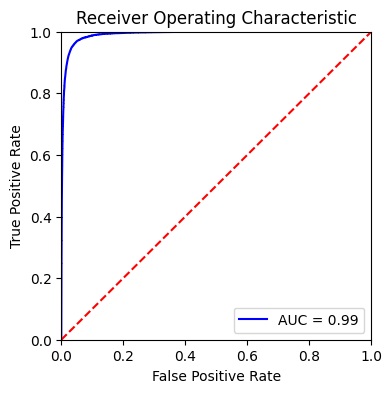

In [40]:
lab_true = []
lab_pred = []
for k,v in firings_mnist.items():
    for p in v:
        lab_true.append(1)
        lab_pred.append(p)
for k,v in firings_emnist.items():
    for p in v:
        lab_true.append(0)
        lab_pred.append(p)

fpr, tpr, threshold = metrics.roc_curve(lab_true, lab_pred)
roc_auc = metrics.auc(fpr, tpr)

fig = plt.figure(figsize =(4, 4))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
writer.add_figure('ROC', fig)

EMNIST VIS:   0%|          | 0/405 [00:00<?, ?it/s]

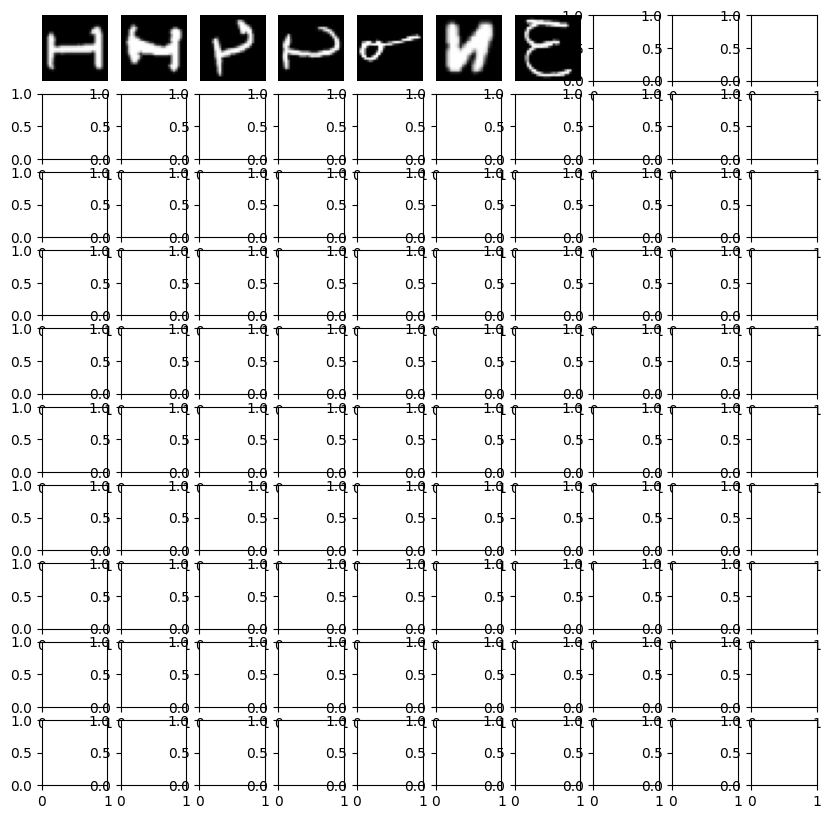

In [41]:
threshold = 0.9
n = 0
fig, ax = plt.subplots(10, 10, figsize=(10, 10))
with torch.no_grad():
    for data, labels in tqdm(emnist_loader, desc='EMNIST VIS'):
        data = data.view((-1, 1, 28, 28)).to(device) 
        arate = get_arate(data)
        winner = arate.max(-1)
        if(winner.values > threshold):
            img = data[winner.indices]
            ax[int(n / 10), int(n % 10)].imshow(img.view(28, 28).cpu().detach().numpy(), cmap='gray')
            ax[int(n / 10), int(n % 10)].axis('off')
            n = n + 1
                
            if n == 100:
                break